# Discover project Ames housing data

# Aanpak van dit project

## Door: Eric Ruis, Laurence Frank

Eerste fase is het begrijpen van de data set. Wat betekenen de variabelen (domein kennis)? Hoe zijn de variablen verdeeld? Zijn er missende waarden, outliers? Welke variabelen correleren met elkaar en met de uitkomst maat?



We beginnen met een setup van python met de meest gebruikte libraries.

In [21]:
# PEP-8: group imports from standard library first, alphabetical order
from pathlib import Path # use pathlib for working with paths
import sys
import tarfile
import warnings

# imports from third-party modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import requests
from requests.compat import urljoin
import sklearn
import seaborn as sns

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# Initialize the random number generator at a specific state to be able reproduce
# the random selections in this notebook
np.random.seed(42)


**Importeren van de data**

There are three versions of the data: the entire data set and the train en test sets of the original data. Import the three versions.

In [22]:
ames = pd.read_csv("https://github.com/jads-nl/discover-projects/blob/main/ames-housing/AmesHousing.csv?raw=true")
ames.shape

(2930, 82)

In [23]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

We ontdekken dat de training data set 80 variabelen bevat, terwijl de orginele data set er 82 heeft. We besluiten om zelf een training / test data set te maken met een verdeling van 70% (training) en 30% (test). 

In [24]:
traindata = ames.sample(frac = 0.7, random_state = 1)
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 2126 to 502
Data columns (total 82 columns):
Order              2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1706 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              141 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         

We hebben nu de training data set aangemaakt, maar nu moeten we nog de test set construeren en die bestaat uit de resterende 30% van de rijen van de originele data set. Maar hoe ga je die nu uit de originele data set halen? Dat kan wel, met een identifierende variabele, bijvoorbeeld het object nummer, `PID` in de data set. Maar dat is wat omslachtig. We kunnen ook gewoon de ingebouwde funcite `train_test_split` gebruiken. 

In [25]:
# Maak training data set en test set.
from sklearn.model_selection import train_test_split

traindata, testdata = train_test_split(ames, test_size=0.3)
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 2210 to 860
Data columns (total 82 columns):
Order              2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1704 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              147 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         

In [26]:
traindata.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2210,2211,909275030,90,RH,82.0,6270,Pave,NaN,Reg,HLS,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,145000
782,783,905325020,20,RL,65.0,25095,Pave,NaN,IR1,Low,...,0,NaN,NaN,NaN,0,6,2009,WD,Partial,143000
2310,2311,527105060,60,RL,60.0,8238,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,183500
299,300,909455040,120,RM,35.0,3907,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,162500
2423,2424,528228415,120,RM,NaN,3072,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,178740


In [27]:
testdata.shape

(879, 82)

In [28]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879 entries, 1357 to 342
Data columns (total 82 columns):
Order              879 non-null int64
PID                879 non-null int64
MS SubClass        879 non-null int64
MS Zoning          879 non-null object
Lot Frontage       736 non-null float64
Lot Area           879 non-null int64
Street             879 non-null object
Alley              51 non-null object
Lot Shape          879 non-null object
Land Contour       879 non-null object
Utilities          879 non-null object
Lot Config         879 non-null object
Land Slope         879 non-null object
Neighborhood       879 non-null object
Condition 1        879 non-null object
Condition 2        879 non-null object
Bldg Type          879 non-null object
House Style        879 non-null object
Overall Qual       879 non-null int64
Overall Cond       879 non-null int64
Year Built         879 non-null int64
Year Remod/Add     879 non-null int64
Roof Style         879 non-null object
Roo

In [29]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

## Checking the missing values

Visualize missing values of a `pandas` data frame: https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj

Another package to explore missing value patterns: missingno

see: https://github.com/ResidentMario/missingno

https://www.kaggle.com/jpmiller/patterns-of-missing-data




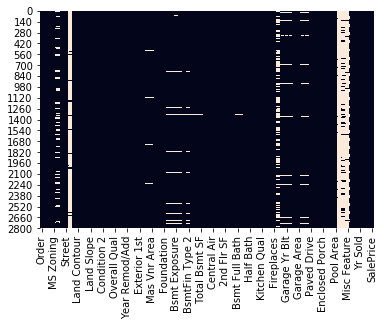

In [30]:
sns.heatmap(ames.isnull(), cbar=False)

In [31]:
ames.describe(exclude = np.object)

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [32]:
ames.describe(include = np.object)

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
count,2930,2930,198,2930,2930,2930,2930,2930,2930,2930,...,2773,2771,2771,2771,2930,13,572,106,2930,2930
unique,7,2,2,4,4,3,5,3,28,9,...,6,3,5,5,3,4,4,5,10,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,2273,2918,120,1859,2633,2927,2140,2789,443,2522,...,1731,1231,2615,2665,2652,4,330,95,2536,2413


Verdeling van de uitkomst variabele, `SalePrice` bekijken. 

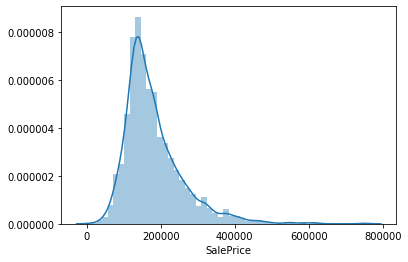

In [33]:
sns.distplot(ames['SalePrice'])

Het is duidelijk dat de verkoop prijs scheef verdeeld is. In de modelering fase nemen we de log van deze variabele. 

In [34]:
ames['SalePrice'].skew()

1.7435000757376466

## Missende waarden aanpassen



In [35]:
# dit is een probeersel
traindata_obj = traindata.select_dtypes(include=['object'])
traindata_obj.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 2210 to 860
Data columns (total 43 columns):
MS Zoning         2051 non-null object
Street            2051 non-null object
Alley             147 non-null object
Lot Shape         2051 non-null object
Land Contour      2051 non-null object
Utilities         2051 non-null object
Lot Config        2051 non-null object
Land Slope        2051 non-null object
Neighborhood      2051 non-null object
Condition 1       2051 non-null object
Condition 2       2051 non-null object
Bldg Type         2051 non-null object
House Style       2051 non-null object
Roof Style        2051 non-null object
Roof Matl         2051 non-null object
Exterior 1st      2051 non-null object
Exterior 2nd      2051 non-null object
Mas Vnr Type      2037 non-null object
Exter Qual        2051 non-null object
Exter Cond        2051 non-null object
Foundation        2051 non-null object
Bsmt Qual         1998 non-null object
Bsmt Cond         1998 non-null ob

In [36]:
traindata_obj.head()

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
2210,RH,Pave,NaN,Reg,HLS,AllPub,Inside,Gtl,Crawfor,Norm,...,2Types,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal
782,RL,Pave,NaN,IR1,Low,AllPub,Inside,Sev,ClearCr,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Partial
2310,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
299,RM,Pave,NaN,IR1,HLS,AllPub,Inside,Mod,Blueste,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2423,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal


Nog een probeersel: kijken of we alle NaN's in objecten kunnen vervangen door '100'. We proberen dit op de kolom `Alley`.

In [37]:
traindata_obj['Alley'].fillna('100', inplace = True)
traindata_obj.head()

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
2210,RH,Pave,100,Reg,HLS,AllPub,Inside,Gtl,Crawfor,Norm,...,2Types,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal
782,RL,Pave,100,IR1,Low,AllPub,Inside,Sev,ClearCr,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Partial
2310,RL,Pave,100,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
299,RM,Pave,100,IR1,HLS,AllPub,Inside,Mod,Blueste,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2423,RM,Pave,100,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [38]:
traindata.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2210,2211,909275030,90,RH,82.0,6270,Pave,NaN,Reg,HLS,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,145000
782,783,905325020,20,RL,65.0,25095,Pave,NaN,IR1,Low,...,0,NaN,NaN,NaN,0,6,2009,WD,Partial,143000
2310,2311,527105060,60,RL,60.0,8238,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,183500
299,300,909455040,120,RM,35.0,3907,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,162500
2423,2424,528228415,120,RM,NaN,3072,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,178740


Nu gaan we echt programmeren. Deze functie vervangt voor categorische variabelen de NaN door de waarde '100' (string) en voor numerieke variabelen de NaN door de mediaan van de betreffende variabele. 

In [39]:
columns = list(traindata)
for i in columns:
    datatype = traindata.dtypes[i]
    if datatype == "object":
        traindata[i].fillna('100', inplace = True)
    else:
        traindata[i].fillna(traindata[i].median(), inplace = True)
        
traindata.head()        
#traindata.info()       

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2210,2211,909275030,90,RH,82.0,6270,Pave,100,Reg,HLS,...,0,100,100,100,0,8,2007,WD,Normal,145000
782,783,905325020,20,RL,65.0,25095,Pave,100,IR1,Low,...,0,100,100,100,0,6,2009,WD,Partial,143000
2310,2311,527105060,60,RL,60.0,8238,Pave,100,IR1,Lvl,...,0,100,100,100,0,5,2006,WD,Normal,183500
299,300,909455040,120,RM,35.0,3907,Pave,100,IR1,HLS,...,0,100,100,100,0,3,2010,WD,Normal,162500
2423,2424,528228415,120,RM,68.0,3072,Pave,100,Reg,Lvl,...,0,100,100,100,0,5,2006,WD,Normal,178740


Check of het gelukt is.

## Variabelen exploreren

We vragen een correlatie heatmap op van de gehele training data set. We kiezen voor een heatmap vanwege het grote aantal variabelen (82).

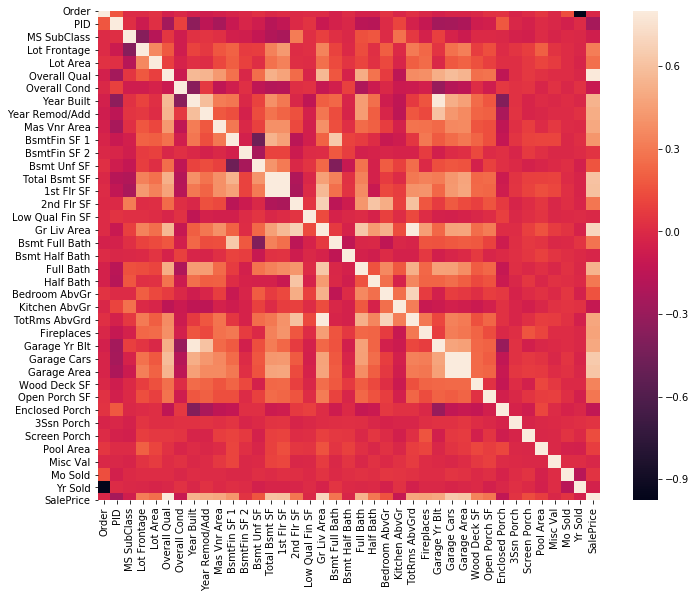

In [40]:
corrmat = traindata.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

# we zouden hier alleen de correlaties tussen continue variabelen moeten opvragen 
# (en evt binair gecodeerde 0,1 variabelen).

In [50]:
traindata_numeric = traindata.select_dtypes(exclude=[np.object])

In [54]:
traindata_numeric.shape

(2051, 39)

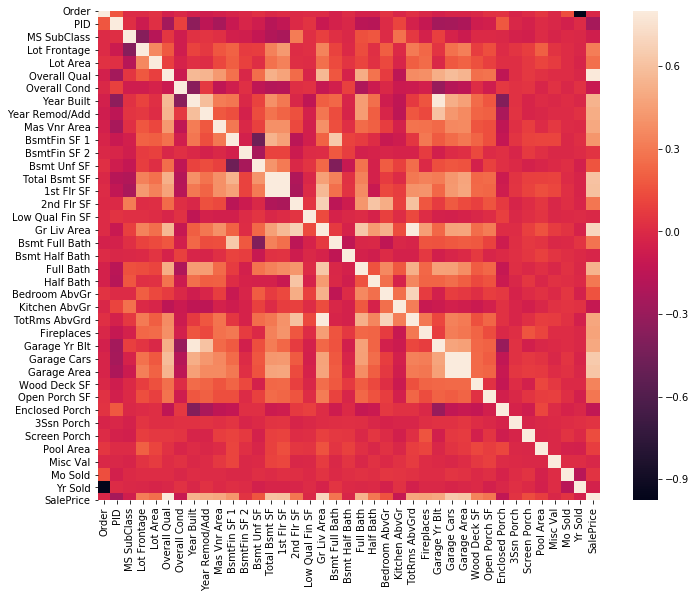

In [49]:
corrmat2 = traindata_numeric.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Vooraf selecteren van de continue variabelen blijkt niet nodig te zijn: de functie correlatie doet dit kennelijk als default. 

Het is toch lastig om in de heatmap een aantal variabelen te selecteren met die een hoge correlatie hebben met de uitkomst maat. Daarom een heatmap van de 10 grootste correlaties. 

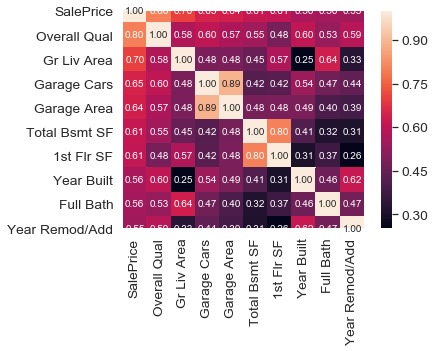

In [45]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index
cm = np.corrcoef(traindata[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

We inspecteren de verdeling van de continue variabelen die voorkomen in de vorige heatmap plot van de 10 hoogste correlaties met de uitkomst maat. 

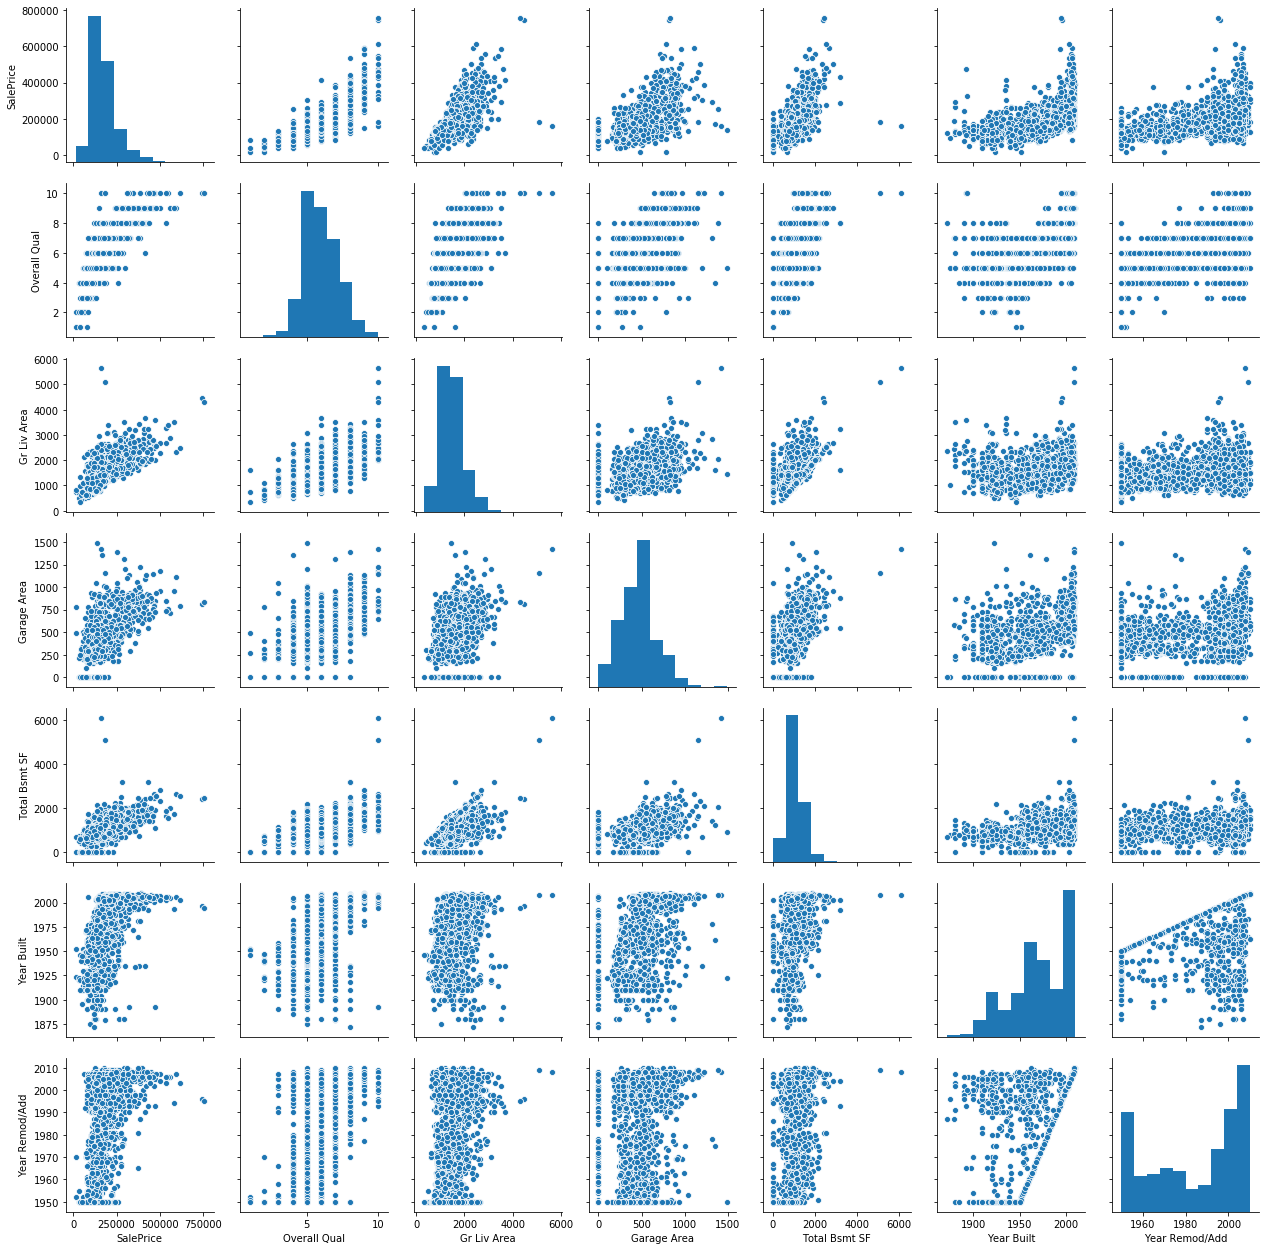

In [43]:
sns.pairplot(traindata[['SalePrice','Overall Qual','Gr Liv Area','Garage Area','Total Bsmt SF',
                        'Year Built', 'Year Remod/Add']]);